## Environment setup

In [1]:
import glob, os
from functools import partial
import importlib

import tensorflow as tf

### Test data set preparation

In [2]:
import io_functions as io
importlib.reload(io)

from architecture_definitions import *

batchSize = 4096
nEpochs=1

#testDataDir = "/scratch_ssd/akalinow/ProgrammingProjects/MachineLearning/OMTF/data/18_12_2020/" 
#testFileNames = glob.glob(testDataDir+'OMTFHits_pats0x0003_newerSample_files_1_100_chunk_0.tfrecord.gzip')

testDataDir = "/scratch_cmsse/alibordi/data/test/"
testFileNames = glob.glob(testDataDir+'SingleMu_iPtX_Feb15_Unfiltered.tfrecord.gzip')

dataset = io.get_LUT_NN_dataset(batchSize, nEpochs, testFileNames, 
                                nRefLayers=nRefLayers,
                                layer1_lut_size=layer1_lut_size,
                                layer2_lut_size=layer2_lut_size,
                                layer2_lutRangesCnt=layer2_lutRangesCnt,
                                last_input_is_bias=last_input_is_bias,
                                rangeFactor=rangeFactor,
                                isTrain=False)

Reading data from files:
/scratch_cmsse/alibordi/data/test/SingleMu_iPtX_Feb15_Unfiltered.tfrecord.gzip


2023-04-19 11:26:09.708144: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-04-19 11:26:09.727801: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-04-19 11:26:09.728442: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-04-19 11:26:09.731533: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags

### Load selected model version

In [3]:
import utility_functions as utils
importlib.reload(utils)

trainingSet = utils.getLatestModelPath(pattern="lut")
print("Using training set:",trainingSet)

job_dir = "results/"+trainingSet
os.makedirs(job_dir, exist_ok=True)

plot_dir = job_dir + "/figures"
os.makedirs(plot_dir, exist_ok=True)

checkpoint_path = "training/"+trainingSet

model = tf.keras.models.load_model(checkpoint_path)
model.summary()

Using training set: 2023_Apr_19_11_06_06_lut_16_8_1
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 layer1 (Custom>LutInterLaye  (None, 16)               313344    
 r)                                                              
                                                                 
 layer2 (Custom>LutInterLaye  (None, 8)                36864     
 r)                                                              
                                                                 
 layer3 (Custom>LutInterLaye  (None, 1)                512       
 r)                                                              
                                                                 
Total params: 350,720
Trainable params: 327,936
Non-trainable params: 22,784
_________________________________________________________________


### Run the model and put the result into Pandas DataFrame

ptGenPtRec.shape (800, 800)
xedges.shape (801,)
yedges.shape (801,)


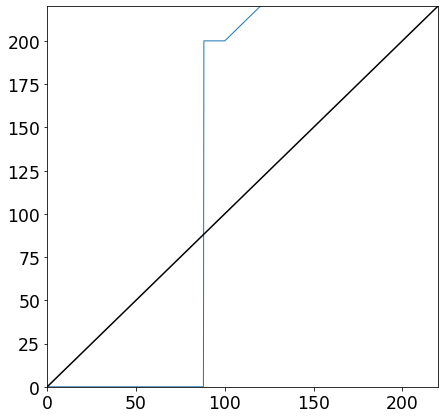

In [7]:
import utility_functions as utils
importlib.reload(utils)

import plotting_functions as plf
importlib.reload(plf)

modelAnswerPostProc = partial(utils.lutNNAnswerPostProc, output_type=output_type)

df = utils.df

for aBatch in dataset: 
    df = utils.fillPandasDataset(aBatch, df, model, modelAnswerPostProc)  
    
df = df[np.abs(df['GEN_eta'])<1.24]
df = df[np.abs(df['GEN_eta'])>0.83]    
    
ptToPtCalibNN, xedges = plf.ptRecalibration(df, plot_dir, oneOverPt, "NN_pt")
df["NN_pt_recalib"] = plf.ptRecalibrated(df["NN_pt"], ptToPtCalibNN, xedges)     

### Make the plots

MeanAbsoluteError NN 68.34665
MeanAbsoluteError NN recalib. 109.99760584691447
MeanAbsoluteError OMTF 103.46009
MeanSquaredError NN 26029.098
MeanSquaredError NN recalib 41676.06242857948
MeanSquaredError OMTF 53310.805
ptCut: 10 qualityCut: 12, eff@plateau: 0.98
ptCut: 15 qualityCut: 12, eff@plateau: 0.98
ptCut: 20 qualityCut: 12, eff@plateau: 0.97
ptCut: 25 qualityCut: 12, eff@plateau: 0.97
ptCut: 30 qualityCut: 12, eff@plateau: 0.96
ptCut: 40 qualityCut: 12, eff@plateau: 0.95
rates NN Rate @10 GeV:35281, @20 GeV: 13461


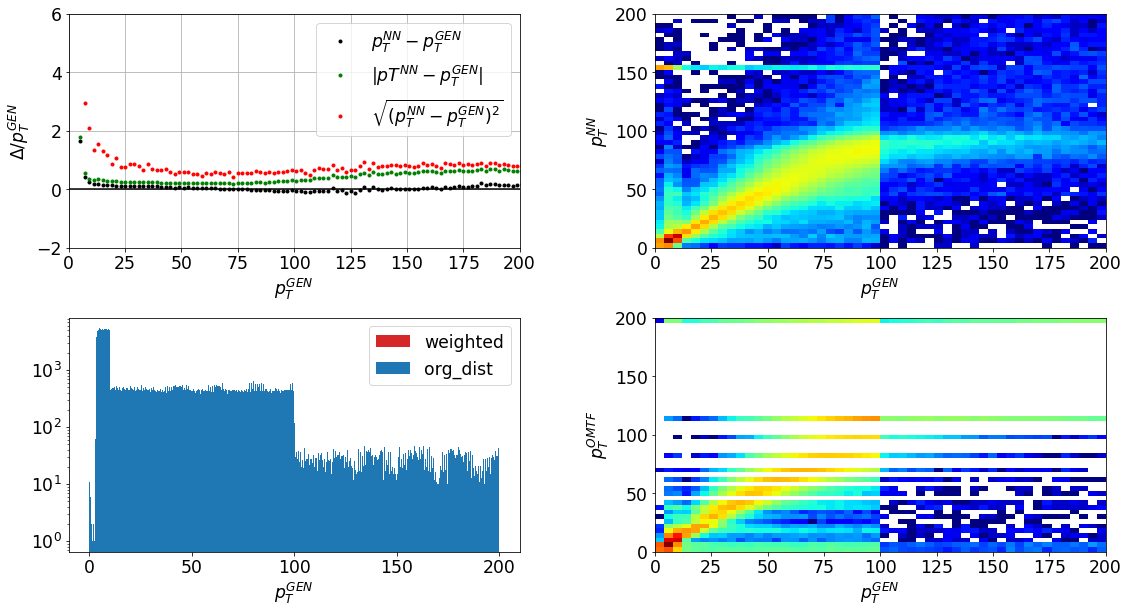

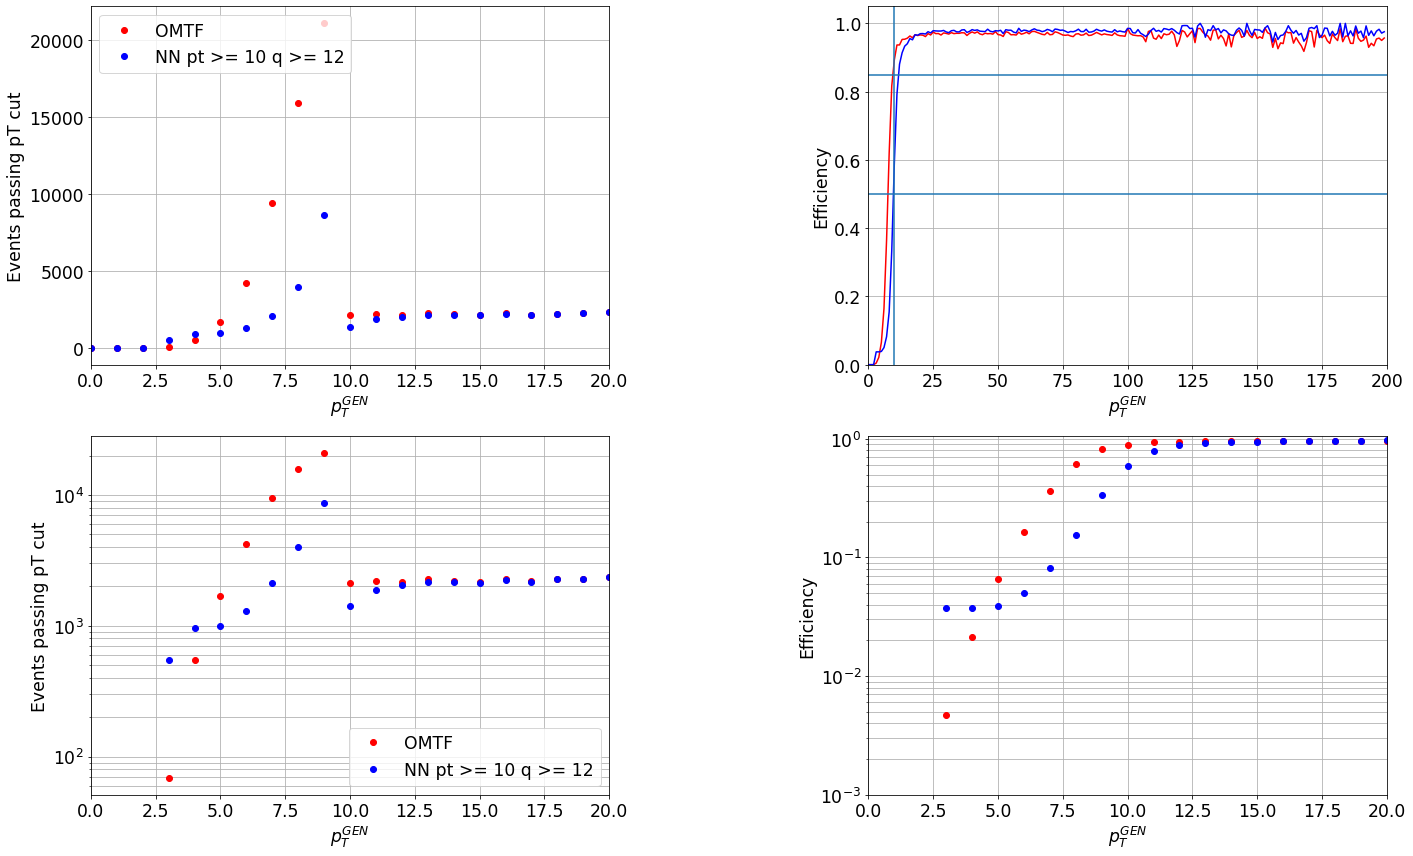

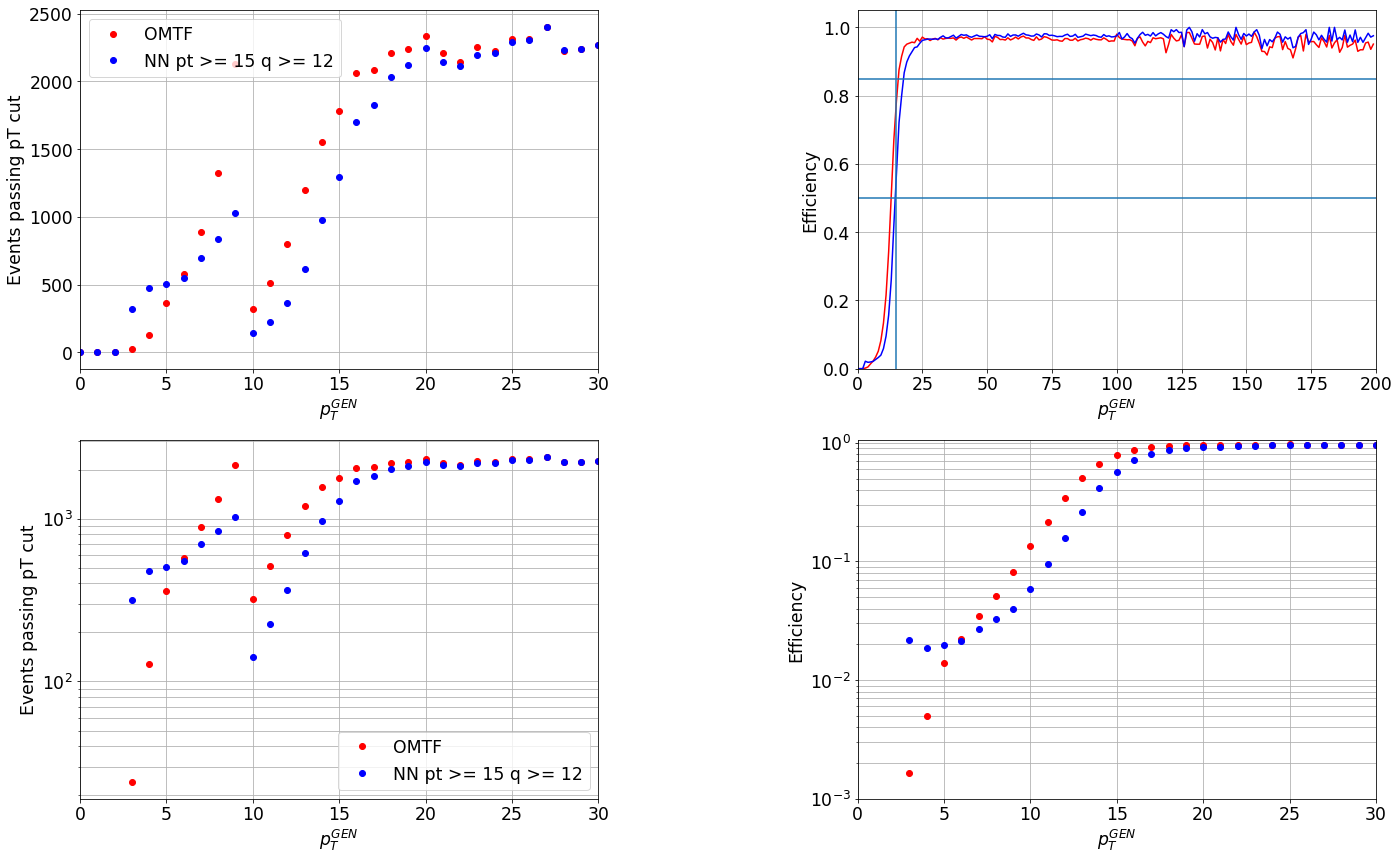

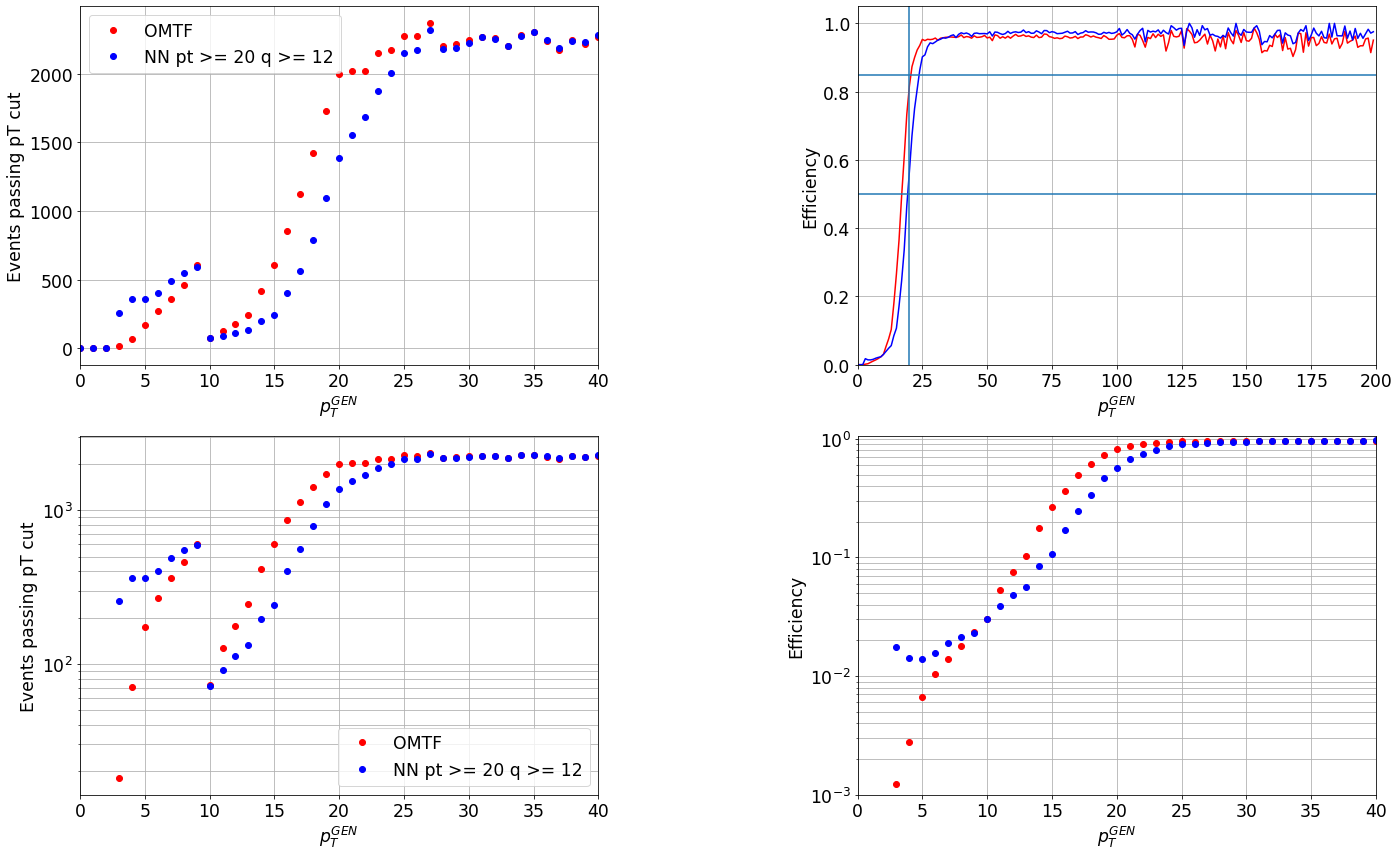

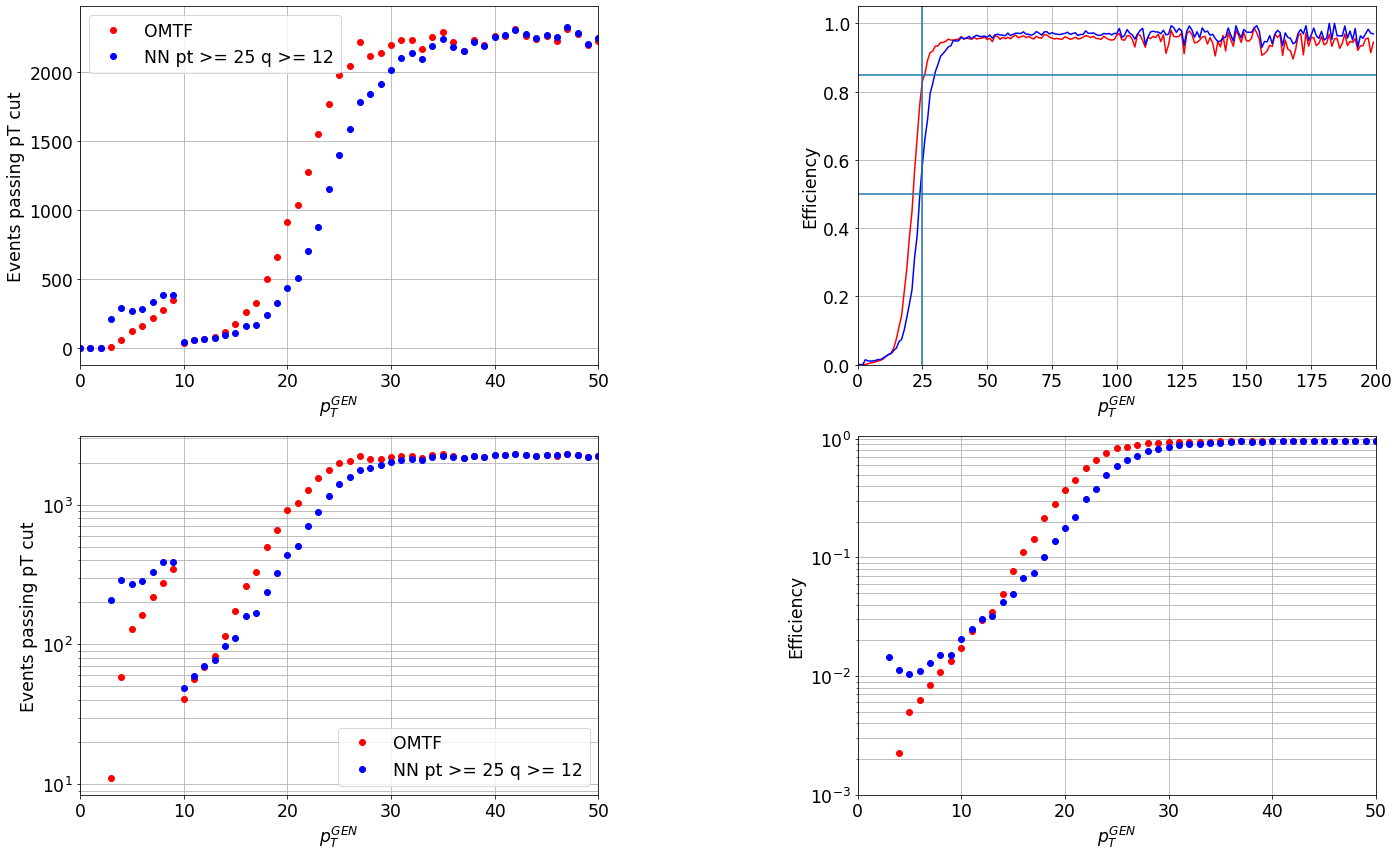

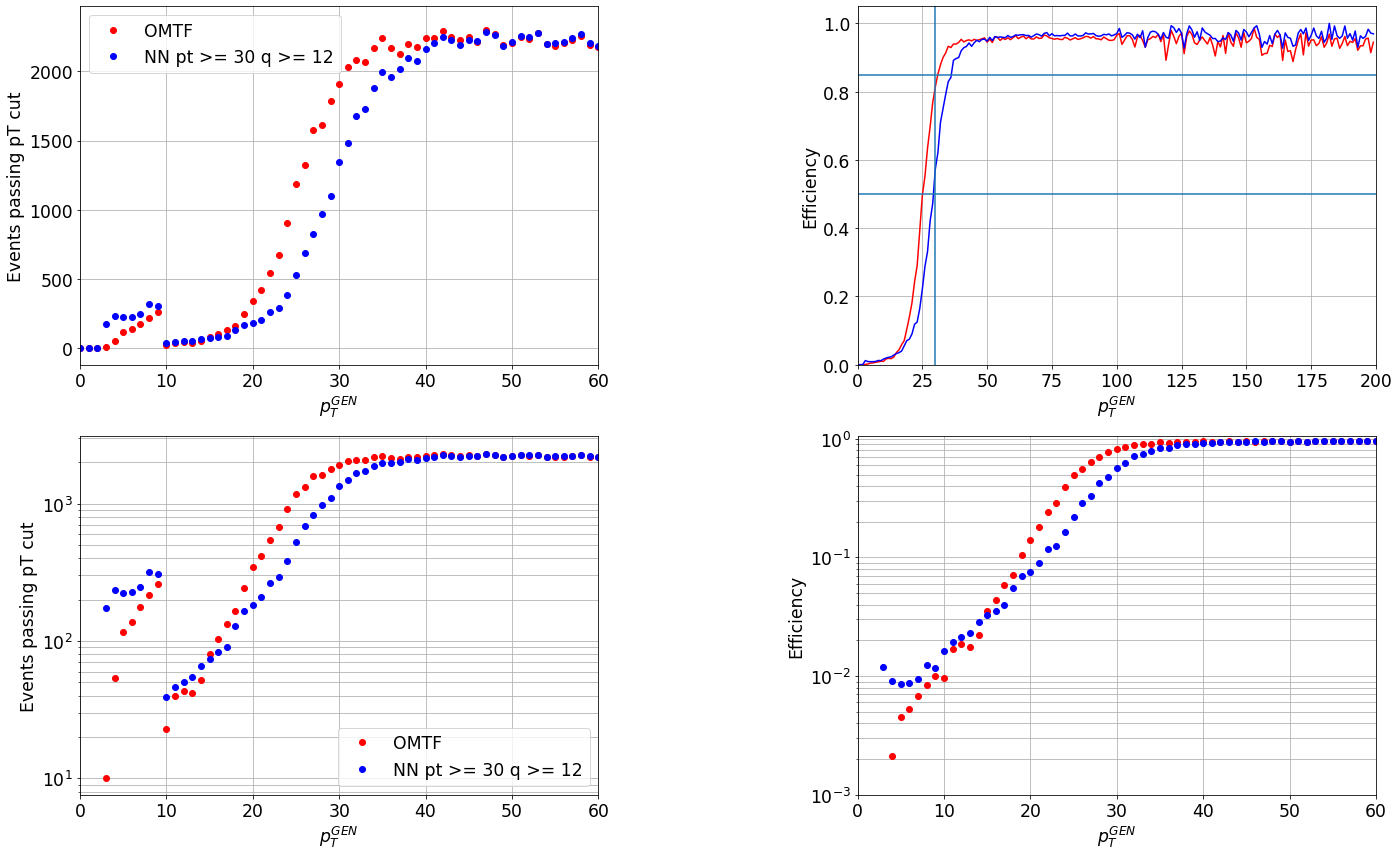

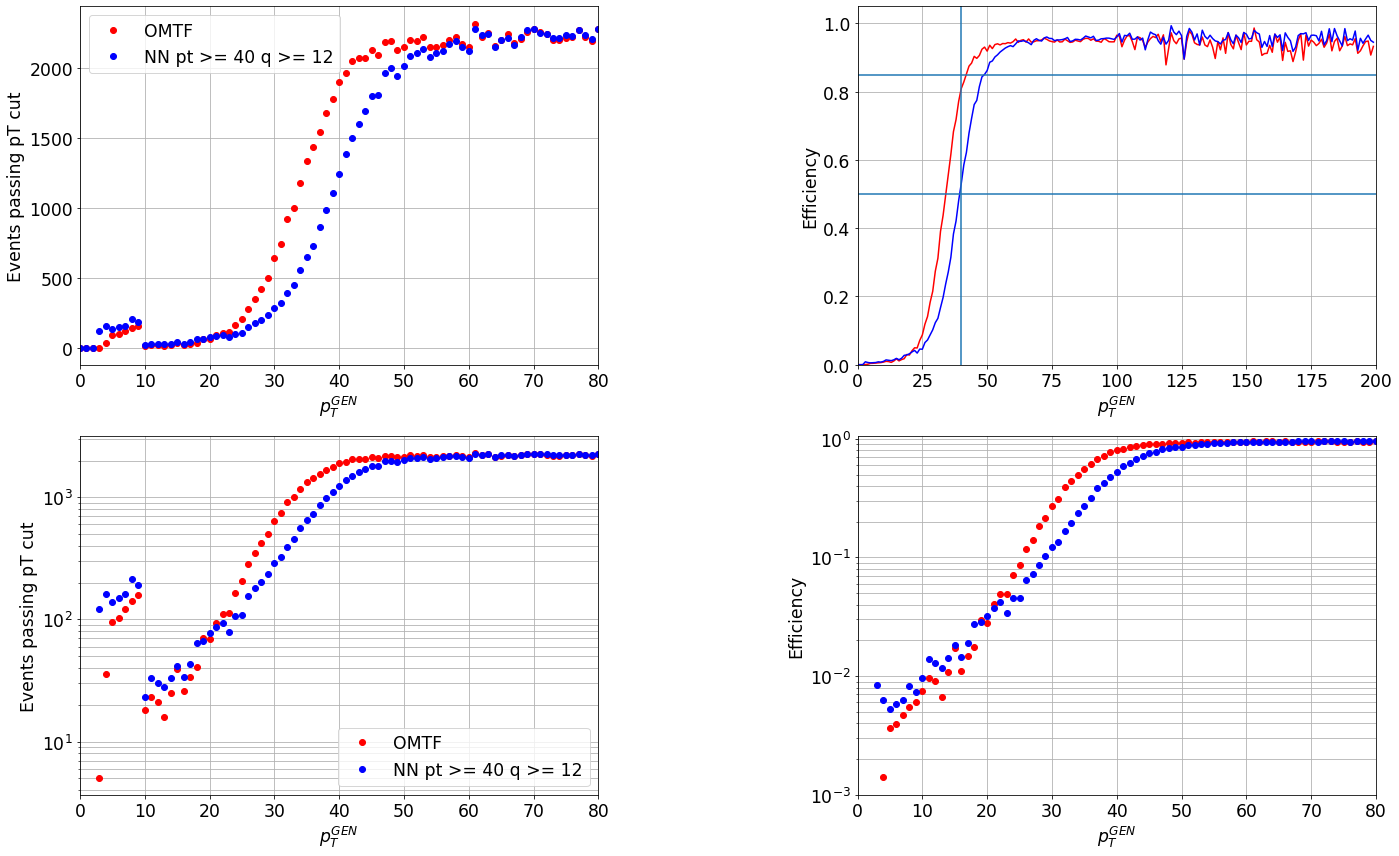

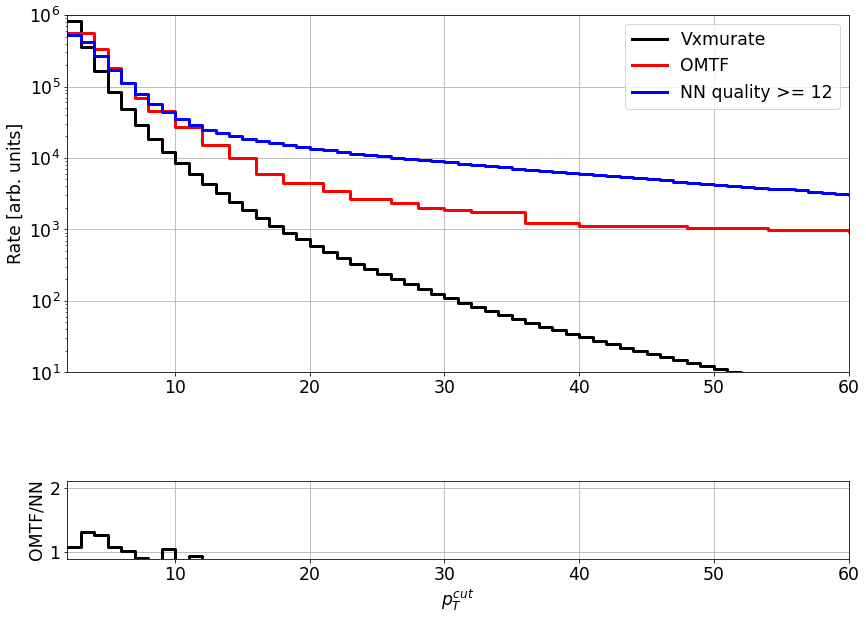

In [8]:
import plotting_functions as plf
importlib.reload(plf)

import utility_functions as utils
importlib.reload(utils)

fileName = job_dir+"/performance.txt"
utils.calculateLossFunctions(df, fileName)

plf.plotPtGenPtRec(df, plot_dir, oneOverPt)

for ptCut in plf.ptCuts :
    effStr, _, _ = plf.plotTurnOn(df, ptCut=ptCut, qualityCut = plf.qualityCut, plotDir=plot_dir)
    utils.appendStringToFile(effStr, fileName)
    print(effStr)

ratesStr = plf.plotRate(df, plf.qualityCut, plotDir=plot_dir)
print("rates NN", ratesStr)

utils.appendStringToFile(ratesStr, fileName)